In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import re
import pprint
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
import seaborn as sns
from datetime import date,datetime

In [2]:
req = requests.get("https://www.nerdwallet.com/blog/mortgages/current-interest-rates/")
bs = BeautifulSoup(req.content,'lxml')
#bs = bs.prettify()
search = bs.find_all('td')

int_rates = pd.DataFrame()
dates = []
year_30 = []
year_15 = []
apr = []
count = 0

for i in search[:1544]:
  if i.get('class')[0] == 'column-1':
    dates.append(i.text)
    continue
  if i.get('class')[0] == 'column-2':
    year_30.append(i.text)
    continue
  if i.get('class')[0] == 'column-3':
    year_15.append(i.text)
    continue
  if i.get('class')[0] == 'column-4':
    apr.append(i.text)
    continue

int_rates['Date'] = dates
int_rates['Date'] = int_rates['Date'].apply(lambda x: pd.to_datetime(x))
int_rates['30-year rate'] = year_30
int_rates['30-year rate'] = int_rates['30-year rate'].str.extract('(\d\D\d\d)')
int_rates['30-year rate'] = int_rates['30-year rate'].apply(float)
int_rates['15-year rate'] = year_15
int_rates['15-year rate'] = int_rates['15-year rate'].str.extract('(\d\D\d\d)')
int_rates['15-year rate'] = int_rates['15-year rate'].apply(float)
int_rates['APR'] = apr
int_rates['APR'] = int_rates['APR'].str.extract('(\d\D\d\d)')
int_rates['APR'] = int_rates['APR'].apply(float)
int_rates.index = int_rates['Date']
int_rates.head(5)
#search

,Date,30-year rate,15-year rate,APR
Date,,,,
2021-03-22,2021-03-22,3.16,2.42,2.76
2021-03-19,2021-03-19,3.27,2.54,3.69
2021-03-18,2021-03-18,3.21,2.51,3.75
2021-03-17,2021-03-17,3.15,2.49,3.84
2021-03-16,2021-03-16,3.17,2.48,3.72


In [3]:
req = requests.get("https://finance.yahoo.com/")
bs = BeautifulSoup(req.content)
search = bs.find_all('script')
#script = bs.find("script",text=re.compile("root.App.main")).text
script = str(bs.find("script",text=re.compile("root.App.main")))

In [4]:
def extract_index_price(ind):
  #Extracting 10000 characters after following the 'quoteData' string which captures the prices for all the indexes
  quotes = script[script.find('quoteData'):script.find('quoteData')+20000]

  #Extracting index price
  price = quotes[quotes.find(ind):quotes.find(ind)+8000]
  current = price[price.find('regularMarketPrice'):price.find('regularMarketPrice')+500]
  prev = price[price.find('regularMarketPreviousClose'):price.find('regularMarketPreviousClose')+500]
  change_per = price[price.find('regularMarketChangePercent'):price.find('regularMarketChangePercent')+500]
  change = price[price.find('regularMarketChange'):price.find('regularMarketChange')+500]

  current = re.findall('("raw":\d+\D\d+|"raw":\d+)',current)[0][6:]
  prev = re.findall('("raw":\d+\D\d+|"raw":\d+)',prev)[0][6:]
  change_per = re.findall('("raw":\d+\D\d+|"raw":\d+)',change_per)[0][6:]
  change = re.findall('("raw":\d+\D\d+|"raw":\d+)',change)[0][6:]
  return (current,prev,change,change_per)

In [5]:
index_futures = ['S&P Futures','Dow Futures','Nasdaq Futures','Russell 2000 Futures','Crude Oil','10-Yr Bond','FTSE 100']
index = ['S&P 500','Dow 30','Nasdaq','Russell 2000','Crude Oil','10-Yr Bond','FTSE 100']

others = ['Gold','Silver','EUR/USD','Nikkei 225','GBP/USE']
price_type = ['regularMarketPrice','regularMarketPreviousClose']
value_curr = []
value_prev = []
value_ch_percent = []
value_ch = []
count = 0

#Checking if the index name has 'Futures'
quotes = script[script.find('quoteData'):script.find('quoteData')+20000]
price = quotes[quotes.find('S&P 500'):quotes.find('S&P 500')+8000]
current = price[price.find('regularMarketPrice'):price.find('regularMarketPrice')+500]

if len(current) == 0: 
  index_list = index_futures
else: 
  index_list = index

for i in index_list:
  count = count + 1
  price_curr,price_prev,price_change,price_change_percent = extract_index_price(i)
  value_curr.append(price_curr)
  value_prev.append(price_prev)
  value_ch_percent.append(price_change_percent)
  value_ch.append(price_change)

indexes = pd.DataFrame()
indexes['Index'] = index_list
indexes['Current'] = value_curr
indexes['Current'] = indexes['Current'].apply(float)
indexes['Prev Close'] = value_prev
indexes['Prev Close'] = indexes['Prev Close'].apply(float)
indexes['Change'] = value_ch
indexes['Change'] = indexes['Change'].apply(float).apply(float)
#indexes['Change Percent'] = value_ch_percent
#indexes['Change Percent'] = indexes['Change Percent'].apply(float)
indexes['Change Percent'] = ((indexes['Current'] - indexes['Prev Close'])/indexes['Prev Close'])*100
indexes.index = indexes['Index']
indexes.head()

,Index,Current,Prev Close,Change,Change Percent
Index,,,,,
S&P Futures,S&P Futures,3919.75,3930.00,3930.00,-0.260814
Dow Futures,Dow Futures,32513.00,32619.00,32619.00,-0.324964
Nasdaq Futures,Nasdaq Futures,13084.50,13071.75,12.75,0.097539
Russell 2000 Futures,Russell 2000 Futures,2236.50,2261.30,2261.30,-1.096714
Crude Oil,Crude Oil,59.34,61.56,61.56,-3.606238


In [6]:
req = requests.get("https://www.worldometers.info/coronavirus/country/us/")
bs = BeautifulSoup(req.content)

div = bs.find_all('div')
cov_data = []

for i in div:
  if i.get('id') == "maincounter-wrap":
    cov_data.append(i)

In [7]:
cases = cov_data[0].find('h1')
cases = cases.text
cases_val = cov_data[0].find('span')
cases_val = cases_val.text

deaths = cov_data[1].find('h1')
deaths = deaths.text
deaths_val = cov_data[1].find('span')
deaths_val = deaths_val.text


rec = cov_data[2].find('h1')
rec = rec.text 
rec_val = cov_data[2].find('span')
rec_val = rec_val.text 

print (cases,':',cases_val)
print (deaths,':',deaths_val)
print (rec,':',rec_val)

cases = {'Cases':cases_val,'Deaths':deaths_val,'Recoveries':rec_val}

Coronavirus Cases: : 30,578,674 
Deaths: : 555,991
Recovered: : 22,846,553


In [8]:
req = requests.get("https://www.nytimes.com/interactive/2020/us/covid-19-vaccine-doses.html")
bs = BeautifulSoup(req.content)
search = bs.find_all('td')

vac_labels = {'Atleast one shot':'g-cell-color','Two shots':'g-border-r','Doses shipped':'distributed','Total shots given':'g-hide-mobile',
              'Doses used':'g-sm'}

atl_one_shot = 0
two_shots = 0
doses_del = 0
shots_given = 0
doses_used = 0

for i in search: 
  cls = i.get('class')
  #distributed is the last word in the list for all <td> tags for vaccine table
  '''
  if cls[-1] == 'g-cell-color':
    atl_one_shot = i.text
  if cls[-1] == 'g-border-r':
    two_shots = i.text
  if cls[-1] == 'distributed':
    doses_del = i.text
  if cls[-1] == 'g-hide-mobile':
    shots_given = i.text
  if cls[-1] == 'g-sm':
    doses_used = i.text
  '''
  #The class names seem to have changed on the website so had to create an alternative parsing method by looking at different keywords in the class
  if cls[-2] == 'pct_given_shot':
    atl_one_shot = i.text
  if cls[-2] == 'g-border-r':
    two_shots = i.text
  if cls[-2] == 'distributed':
    doses_del = i.text
  if cls[-2] == 'given':
    shots_given = i.text
  if cls[-2] == 'pct_doses_given':
    doses_used = i.text
    break
    
vac_values = [atl_one_shot,two_shots,doses_del,shots_given,doses_used]
vac_values = list(map(str.strip,vac_values))

print ("At least 1 shot given: ",atl_one_shot)
print ("Two shots given: ",two_shots)
print ("Total doses delivered: ",doses_del)
print("Total shots given: ",shots_given)
print("Doses used: ",doses_used)

At least 1 shot given:  
25%

Two shots given:  
14%

Total doses delivered:  
156,734,555

Total shots given:  
126,509,736

Doses used:  
81%



In [9]:
vix = yf.Ticker("^VIX")

# get stock info
print (vix.info['regularMarketPrice'])
print (vix.info['regularMarketPreviousClose'])
print (vix.info['regularMarketOpen'])
print (vix.info['dayHigh'])
print (vix.info['dayLow'])
print (vix.info['fiftyTwoWeekHigh'])
print (vix.info['fiftyTwoWeekLow'])

19.46
20.95
19.46
19.95
19.36
69.1
18.95


In [10]:
def extract_treasury_rates(url):
  req = requests.get(url)
  bs = BeautifulSoup(req.content,'lxml')
  search = bs.find_all('td')

  df_rates = pd.DataFrame()
  rates = []
  dates = []
  count = 0
  count2 = 0

  for i in search:
    if count == 1: 
      dates.append(i.text)
      count = 0
      continue
    if i.get('class'):
      if i.get('class')[0] == 'text-right':  
        count = 1
        rates.append(i.text)
  all_dates = [date.today() - pd.to_timedelta('1D')]
  all_dates.extend(dates[:-1])
  
  df_rates['date'] = all_dates[:50]
  df_rates['date'] = df_rates['date'].apply(pd.to_datetime)
  df_rates['rate'] = rates[:50]
  df_rates['rate'] = df_rates['rate'].apply(str.strip)
  df_rates['rate'] = df_rates['rate'].str.strip('%')

  return df_rates['rate'], df_rates['date']

In [11]:
rate_1m,date_10 = extract_treasury_rates('https://ycharts.com/indicators/1_month_treasury_rate')
rate_3m,date_10 = extract_treasury_rates('https://ycharts.com/indicators/3_month_treasury_rate')
rate_6m,date_10 = extract_treasury_rates('https://ycharts.com/indicators/6_month_treasury_rate')
rate_1,date_10 = extract_treasury_rates('https://ycharts.com/indicators/1_year_treasury_rate')
rate_3,date_10 = extract_treasury_rates('https://ycharts.com/indicators/3_year_treasury_rate')
rate_5,date_10 = extract_treasury_rates('https://ycharts.com/indicators/5_year_treasury_rate')
rate_10,date_10 = extract_treasury_rates('https://ycharts.com/indicators/10_year_treasury_rate')
rate_20,date_20 = extract_treasury_rates('https://ycharts.com/indicators/20_year_treasury_rate')
rate_30,date_30 = extract_treasury_rates('https://ycharts.com/indicators/30_year_treasury_rate')

df_rates = pd.DataFrame()
df_rates['1-mth'] = rate_1m.apply(float)
df_rates['3-mth'] = rate_3m.apply(float)
df_rates['6-mth'] = rate_6m.apply(float)
df_rates['1-yr'] = rate_1.apply(float)
df_rates['3-yr'] = rate_3.apply(float)
df_rates['5-yr'] = rate_5.apply(float)
df_rates['10-yr'] = rate_10.apply(float)
df_rates['20-yr'] = rate_20.apply(float)
df_rates['30-yr'] = rate_30.apply(float)

df_rates['date'] = date_10
df_rates.index = df_rates['date'].apply(pd.to_datetime)

df_rates.head()

,1-mth,3-mth,6-mth,1-yr,3-yr,5-yr,10-yr,20-yr,30-yr,date
date,,,,,,,,,,
2021-03-22,0.02,0.03,0.05,0.06,0.32,0.87,1.69,2.29,2.38,2021-03-22
2021-03-19,0.01,0.01,0.03,0.07,0.33,0.90,1.74,2.36,2.45,2021-03-19
2021-03-18,0.01,0.01,0.03,0.08,0.33,0.86,1.71,2.36,2.45,2021-03-18
2021-03-17,0.01,0.02,0.05,0.07,0.29,0.80,1.63,2.32,2.42,2021-03-17
2021-03-16,0.01,0.02,0.06,0.07,0.33,0.83,1.62,2.30,2.38,2021-03-16


In [12]:
yield_curve = df_rates.iloc[0,:-1]
yield_curve

1-mth    0.02
3-mth    0.03
6-mth    0.05
1-yr     0.06
3-yr     0.32
5-yr     0.87
10-yr    1.69
20-yr    2.29
30-yr    2.38
Name: 2021-03-22 00:00:00, dtype: object

In [ ]:
req = requests.get('https://data.bls.gov/timeseries/LNS14000000')
bs = BeautifulSoup(req.content,'lxml')
search = bs.find_all('td')

count = 0
years = 0
time_list = []
rates = []
dates = []

for i in search[6:]:
  count = count + 1
  time_list.append(count)
  rates.append(i.text)
  if count == 12: 
    years = years + 1
    count = 0 

year_list = []
for i in range(date.today().year-years+1,date.today().year+1):
  year_list.extend([i]*12)

count = 0
for i in rates: 
  dates.append(pd.to_datetime(str(time_list[count])+'/1/'+str(year_list[count])))
  count = count + 1

df_unemp_rate = pd.DataFrame()
df_unemp_rate['date'] = dates
df_unemp_rate['unemployment_rate_percent'] = rates  
df_unemp_rate['unemployment_rate_percent'] = df_unemp_rate['unemployment_rate_percent'].str.strip()
df_unemp_rate['unemployment_rate_percent'] = df_unemp_rate['unemployment_rate_percent'].replace('',np.nan)
df_unemp_rate['unemployment_rate_percent'] = df_unemp_rate['unemployment_rate_percent'].apply(float)

df_unemp_rate.index = df_unemp_rate['date']
df_unemp_rate = df_unemp_rate.dropna()
df_unemp_rate.head()

In [13]:
req = requests.get('https://www.usinflationcalculator.com/inflation/historical-inflation-rates/')
bs = BeautifulSoup(req.content,'lxml')
search = bs.find_all('td')

count = 0
years = 0
time_list = []
rates = []
dates = []

for i in search:
  count = count + 1
  if count == 13:
    years = years + 1
    count = 0 
    continue
  time_list.append(count)
  rates.append(i.text)

time_list = time_list[:-6]
rates = rates[:-6]

year_list = []
for i in range(date.today().year-years+1,date.today().year+1):
  year_list.extend([i]*12)

count = 0
for i in rates: 
  dates.append(pd.to_datetime(str(time_list[count])+'/1/'+str(year_list[count])))
  count = count + 1

df_inflation = pd.DataFrame()
df_inflation['date'] = dates
df_inflation['inflation_rate'] = rates  
df_inflation['inflation_rate'] = df_inflation['inflation_rate'].str.strip()
df_inflation['inflation_rate'] = df_inflation['inflation_rate'].replace('',np.nan)
df_inflation['inflation_rate'] = df_inflation['inflation_rate'].apply(float)

df_inflation.index = df_inflation['date']
df_inflation = df_inflation.dropna()
df_inflation.head()

,date,inflation_rate
date,,
1914-01-01,1914-01-01,2.0
1914-02-01,1914-02-01,1.0
1914-03-01,1914-03-01,1.0
1914-04-01,1914-04-01,0.0
1914-05-01,1914-05-01,2.1


In [14]:
req = requests.get('https://www.multpl.com/us-gdp-inflation-adjusted/table/by-year')
bs = BeautifulSoup(req.content,'lxml')
search = bs.find_all('td')

dates = []
gdp = []

count = 0

for i in search: 
  count = count + 1
  if count == 1:
    dates.append(i.text)
  if count == 2: 
    gdp.append(i.text)
    count = 0

df_gdp = pd.DataFrame()
df_gdp['date'] = dates
df_gdp['date'] = df_gdp['date'].apply(pd.to_datetime)
df_gdp['gdp'] = gdp
df_gdp['gdp'] = df_gdp['gdp'].str.strip()
df_gdp['gdp'] = df_gdp['gdp'].str.extract('(\d+\D\d+)')
df_gdp['gdp'] = df_gdp['gdp'].apply(float)
df_gdp.index = df_gdp['date']
df_gdp.head()

,date,gdp
date,,
2020-12-31,2020-12-31,18.78
2019-12-31,2019-12-31,19.25
2018-12-31,2018-12-31,18.81
2017-12-31,2017-12-31,18.36
2016-12-31,2016-12-31,17.88


In [21]:
def dash_create():
  plt.rcParams.update(plt.rcParamsDefault)
  %matplotlib inline
  plt.style.use('bmh')

  fig3 = plt.figure(constrained_layout=True,figsize=(60,60))
  gs = fig3.add_gridspec(40,3)

  f3_ax1 = fig3.add_subplot(gs[0:10,0])
  #plt.subplot(2,3,1)
  '''plt.plot(df_unemp_rate['unemployment_rate_percent'],alpha=0.8,label='Unemployment rate (%)',color='green')
  plt.plot(df_inflation.iloc[df_inflation.index>'2011']['inflation_rate'],alpha=0.8,label='Inflation rate (%)',color='blue')
  plt.xticks(rotation=0,size=20)
  plt.xlabel('Timeline',size=25)
  plt.yticks(size=20)
  plt.ylabel('Rate (%)',size=25)
  plt.title('Critical Economic Indicators',size=30)
  #plt.axis('off')
  plt.legend(prop={'size':15})'''

  f3_ax2 = fig3.add_subplot(gs[11:21,0])
  plt.plot(df_gdp.iloc[df_gdp.index>'2011']['gdp'],marker='o',alpha=0.8,label='GDP',color='orange')
  plt.xticks(rotation=0,size=20)
  plt.xlabel('Timeline',size=25)
  plt.yticks(size=20)
  plt.ylabel('$ (Trillion)',size=25)
  plt.legend(prop={'size':15})

  f3_ax3 = fig3.add_subplot(gs[0:10,1])
  #plt.subplot(2,3,2)
  plt.plot(df_rates['1-mth'],label=df_rates.columns[0],alpha=1)
  plt.plot(df_rates['3-mth'],label=df_rates.columns[1],alpha=1)
  plt.plot(df_rates['6-mth'],label=df_rates.columns[2],alpha=1)
  plt.plot(df_rates['1-yr'],label=df_rates.columns[3],alpha=1)
  plt.plot(df_rates['3-yr'],label=df_rates.columns[4],alpha=1)
  plt.plot(df_rates['5-yr'],label=df_rates.columns[5],alpha=1)
  plt.plot(df_rates['10-yr'],label=df_rates.columns[6],alpha=1)
  plt.plot(df_rates['20-yr'],label=df_rates.columns[7],alpha=1)
  plt.plot(df_rates['30-yr'],label=df_rates.columns[8],alpha=1)
  plt.xticks(rotation=0,size=20)
  plt.xlabel('Timeline',size=25)
  plt.yticks(size=20)
  plt.ylabel('Rate (%)',size=25)
  plt.title('U.S. Treasury Yield Rates (last 3 months)',size=30)
  #plt.axis('off')
  plt.legend(loc='upper left',prop={'size':15})

  f3_ax3 = fig3.add_subplot(gs[11:21,1])
  plt.plot(yield_curve,marker='o')
  plt.xticks(yield_curve.index,rotation=15,size=20)
  plt.yticks(size=20)
  plt.ylabel('Rate (%)',size=25)
  plt.xlabel('Treasury Security',size=25)
  
  vix_data = {"MarketPrice":vix.info['regularMarketPrice'],"PreviousClose":vix.info['regularMarketPreviousClose'],"MarketOpen":vix.info['regularMarketOpen'],"DayHigh":vix.info['dayHigh'],"DayLow":vix.info['dayLow']}
  f3_ax4 = fig3.add_subplot(gs[0:10,2])  
  #plt.subplot(2,3,3)
  plots = sns.barplot(y="Change Percent", x="Index", data=indexes,alpha=0.8) 
    
  # Iterrating over the bars one-by-one 
  for bar in plots.patches: 
    # Using Matplotlib's annotate function and 
    # passing the coordinates where the annotation shall be done 
    # x-coordinate: bar.get_x() + bar.get_width() / 2 
    # y-coordinate: bar.get_height() 
    # free space to be left to make graph pleasing: (0, 8) 
    # ha and va stand for the horizontal and vertical alignment 
      plots.annotate(format(bar.get_height(), '.2f'),  
                    (bar.get_x() + bar.get_width() / 2,bar.get_height()+0.6), ha='center', va='center', 
                    size=20, xytext=(0,8), 
                    textcoords='offset points')  
  plt.xlabel('Index',size=25)
  plt.ylabel('Change (%)',size=25)
  plt.title('Major Indexes',size=30)
  #plt.axis('off')
  plt.xticks(size=20)
  plt.yticks(size=20)

  f3_ax4 = fig3.add_subplot(gs[11:21,2])  
  #plt.subplot(2,3,3)
  plots = sns.barplot(y="Current", x="Index", data=indexes,alpha=0.8) 
    
  # Iterrating over the bars one-by-one 
  for bar in plots.patches: 
    # Using Matplotlib's annotate function and 
    # passing the coordinates where the annotation shall be done 
    # x-coordinate: bar.get_x() + bar.get_width() / 2 
    # y-coordinate: bar.get_height() 
    # free space to be left to make graph pleasing: (0, 8) 
    # ha and va stand for the horizontal and vertical alignment 
      plots.annotate(format(bar.get_height(), '.2f'),  
                    (bar.get_x() + bar.get_width() / 2,bar.get_height()+0.6), ha='center', va='center', 
                    size=20, xytext=(0,8), 
                    textcoords='offset points')  
  plt.xlabel('Index',size=25)
  plt.ylabel('Current Value',size=25)
  #plt.title('Major Indexes (current value)',size=25)
  #plt.axis('off')
  plt.xticks(size=20)
  plt.yticks(size=20)

  vix_data = {"MarketPrice":vix.info['regularMarketPrice'],"PreviousClose":vix.info['regularMarketPreviousClose'],"MarketOpen":vix.info['regularMarketOpen'],"DayHigh":vix.info['dayHigh'],"DayLow":vix.info['dayLow']}

  df_vix = pd.DataFrame()
  df_vix['Stat'] = list(vix_data.keys())
  df_vix['Value'] = list(vix_data.values())

  f3_ax5 = fig3.add_subplot(gs[22:40,0])
  #plt.subplot(2,3,4)
  plots = sns.barplot(y="Stat", x="Value", data=df_vix,alpha=0.7,palette='YlOrBr') 
    
  # Iterrating over the bars one-by-one 
  for bar in plots.patches: 
    # Using Matplotlib's annotate function and 
    # passing the coordinates where the annotation shall be done 
    # x-coordinate: bar.get_x() + bar.get_width() / 2 
    # y-coordinate: bar.get_height() 
    # free space to be left to make graph pleasing: (0, 8) 
    # ha and va stand for the horizontal and vertical alignment 
      plots.annotate(format(bar.get_width(), '.2f'),  
                    (bar.get_width()-2,bar.get_y() + bar.get_height() / 2), ha='center', va='center', 
                    size=25, xytext=(8,0), 
                    textcoords='offset points')  
  plt.xlabel('Values',size=25)
  plt.ylabel('Data',size=25)
  plt.title('CBOE Volatility Index - VIX Indicator',size=30)
  plt.xticks(size=20)
  plt.yticks(size=20)

  f3_ax6 = fig3.add_subplot(gs[22:40,1])
  #plt.subplot(2,3,5)
  x = [2,3,4]
  y = [18,-22,18]
  c = ['blue','red','blue']
  count = 0
  plt.scatter(x,y,s=65000,alpha=0.3,c='red')
  for i,j in zip(x,y):
    plt.annotate(list(cases.keys())[count],xy=(i-0.5,j),size=20)
    plt.annotate(list(cases.values())[count],xy=(i-0.5,j-5),size=30)
    count = count + 1
  plt.axis('off')
  plt.xlim(0,6)
  plt.xticks(size=20)
  plt.ylim(-50,50)
  plt.title('COVID-19 Cases',size=30)

  f3_ax7 = fig3.add_subplot(gs[22:40,2])
  #plt.subplot(2,3,6)
  x = [1,2,3,4,5]
  y = [18,-22,18,-22,18]
  c = ['blue','red','blue','red','blue']
  count = 0
  plt.scatter(x,y,s=65000,alpha=0.3,c='green')
  for i,j in zip(x,y):
    plt.annotate(list(vac_labels.keys())[count],xy=(i-0.5,j),size=20)
    plt.annotate(vac_values[count],xy=(i-0.5,j-5),size=30)
    count = count + 1
  plt.axis('off')
  plt.xlim(0,6)
  plt.xticks(size=25)
  plt.ylim(-50,50)
  plt.title('COVID-19 Vaccinations',size=30)

  plt.tight_layout(pad=4)

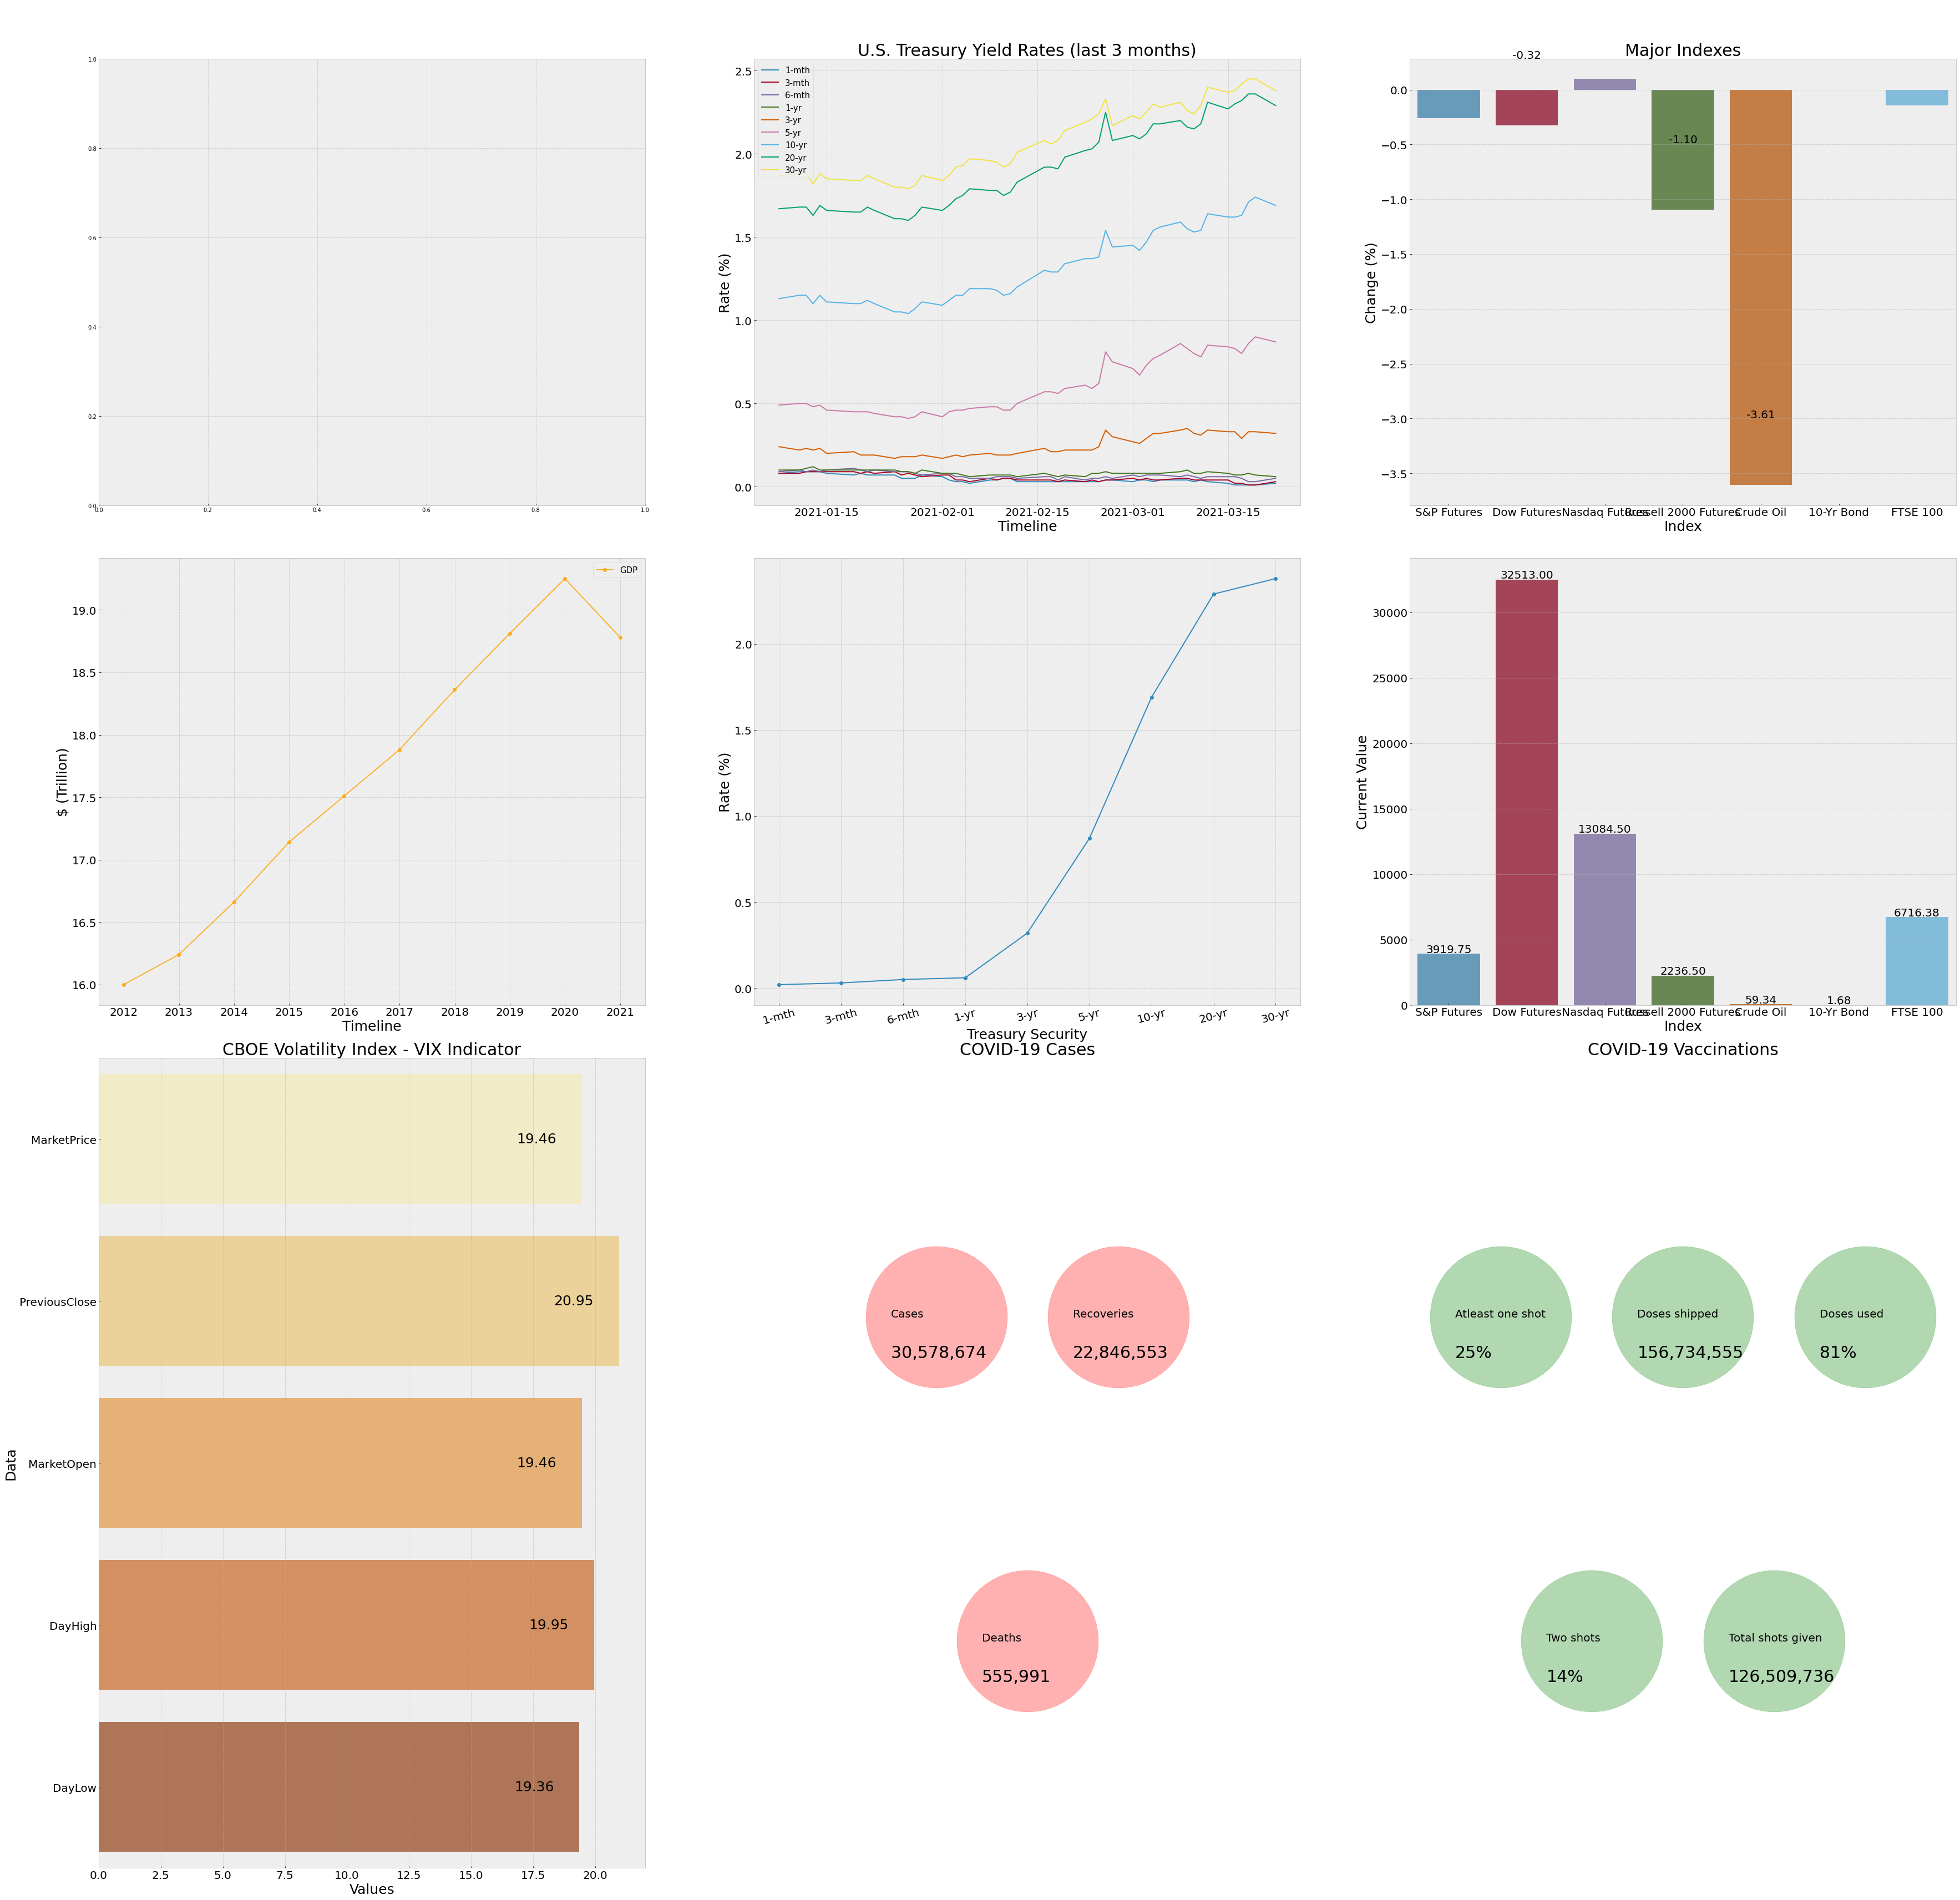

In [22]:
dash_create()